This notebook can be [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-2/blob/main/HW2.0_Backpropagation.ipynb).


# Homework 2.0: Backpropagation

Homework 2 has several parts.  In this first part, we will work with backpropagation.

## Learning Objective

In this part of the homework you will implement the core part of the backpropagation algorithm by hand and understand its use of memory and time.

## Readings

[Rumelhart, Hinton and Williams, *Learning representations
by back-propagating errors*, 1986](https://papers.baulab.info/Rumelhart-1986.pdf) - Very influential in popularizing backpropagation, also known to numerical analysts as "reverse mode autodifferentiation".

[Andreas Griewank, *On automatic differentiation and algorithmic linearization*, 2014](https://papers.baulab.info/also/Griewank-2014.pdf) - A mathematical presentation of both the forward and reverse-mode algorithm.  Since in deep network training we tpically have a single-dimensional scalar loss, we only focus on reverse-mode, which is far more efficient for our case.  May be helpful in the axioms and examples it provides.

[Andreas Griewank, *Who invented the reverse mode of differentiation?*, 2012](https://papers.baulab.info/also/Griewank-2012.pdf) - Of historical interest.

## Exercise 2.0.1: Implement backpropagation on paper

Backpropagation is based on the idea of computing gradients efficently by remembering and reusing partial results.

Consider the hyperbolic cosine function

$$
z = \cosh{x} = \frac{e^x + e^{-x}}{2}
$$

First, just compute $\frac{dz}{dx}$ using ordinary calculus.  It turns out this is the sinh function:

$$
\frac{dz}{dx} = \sinh{x} = \boxed{\text{TODO: $\frac{e^x - e^{-x}}{2}$}}
$$

Now, let's compute these numerically using backpropagation, done by hand.  Here is the computation graph for cosh:

<img src="https://cs7150.baulab.info/2022-Fall/hw2/cosh-backprop.png">

First, fill in the forward pass.  Compute and fill in the following values in order.  You can write the answers in terms of `log` where it is cleaner, e.g., `log 0.5` or `log 2`, etc.   (Tip: it is much easier to work out the forward and backward pass by using a pencil and paper by drawing the graph and filling it out; then you can copy your answers here)

$$
a = \boxed{\text{TODO: log 2}}
$$

$$
b = \boxed{\text{TODO: $e^{log 2}$}}
$$

$$
c = \boxed{\text{TODO: log 2}}
$$

$$
d = \boxed{\text{TODO: - log 2}}
$$

$$
e = \boxed{\text{TODO: $e^{- log 2}$}}
$$

$$
z = \boxed{\text{TODO: $\frac{e^{log 2} + e^{-log 2}}{2}$}}
$$

Now, fill in the backward pass, in the reverse order.

$$
\frac{\partial z}{\partial z} = \boxed{\text{TODO: 1}}
$$

$$
\frac{\partial z}{\partial e} = \boxed{\text{TODO: $\frac{1}{2}$}}
$$

$$
\frac{\partial z}{\partial d} = \boxed{\text{TODO:  $\frac{1}{2}$ * $e^{-log2}$}}
$$

$$
\frac{\partial z}{\partial c} = \boxed{\text{TODO: $\frac{-1}{2}$ * $e^{-log2}$}}
$$

$$
\frac{\partial z}{\partial b} = \boxed{\text{TODO: $\frac{1}{2}$}}
$$

$$
\frac{\partial z}{\partial a} = \boxed{\text{TODO: $\frac{1}{2}$ * $e^{log2}$}}
$$

$$
\frac{\partial z}{\partial x} = \boxed{\text{TODO: $\frac{e^{log 2} - e^{-log 2}}{2}$}}
$$

Check your final answer for $\frac{\partial z}{\partial x}$ against the value of sinh.  It should match.

The "copy" operation occurs frequently but is typically not explicitly represented as a computation node in code.  Instead, we see it appear as *gradient accumulation*, where multiple backward paths leading to the same node provide gradient that is summed and accumulated over all the paths.  That is the case in the code below.

Me and Sai Vineeth kaza has collaborated for this exercise

## Exercise 2.0.2: implement backpropagation in code

The `ComputationNode` base class below provides a starting point for implementing the backpropagation algorithm.  A computation graph is created by connecting a set of `ComputationNodes`, culminating in a single output.  Every node records:

* A list of any number of input edges connecting to input nodes, connected at construction (`self.input_nodes`)
* A single output, where the result will be stored as a number computed in the forward pass (`self.result`)
* A single gradient, which is the accumulated upstream gradient computed in the backward pass (`self.gradient`)

Because a computation graph ends at a single output which is recursively connected to the result of the graph through the input edges, the whole graph can be represented by a reference to the output node.

The `ComputationNode` base class itself does not know how to compute any specific mathematical operation.  Each separate math operation will need a subclass.  `Leaf`, `Negate`, `Exp`, and `Mean` are provided as examples.

Each node also comes with convenience methods for traversing the computation graph that ends at the given node:

* `sorted_nodes()` returns a list of all the computation nodes in toplogically sorted order, output last.
* `get(name)` finds the single node matching the given name.

In addition, similar to pytorch, the base class provides several convenience methods to compute the negation, exponent, etc, by constructing computation nodes that take the current node as input.

Read and familiarize yourself with the code below.

In [ ]:
# Do not change the code in this cell.
import math

class ComputationNode:
    def __init__(self, *input_nodes, name=None):
        '''
        A computation graph is an acyclic graph of nodes, each representing
        a value that is computed from its child (predecessor) input_nodes.
        In our implementation, you must give the input nodes at construction time,
        and we do not compute the result or the gradient right away.
        That is your job.
        '''
        self.name = name
        self.input_nodes = [n if isinstance(n, ComputationNode) else Leaf(n)
                            for n in input_nodes]
        self.result = None
        self.gradient = None
    def forward(self):
        '''One step of the forward pass will fill in self.result.'''
        assert 'Subclass implementation needed'
        self.result = function_of(self.input(0))
    def backward(self):
        '''One step of the backward pass will combine upstream `self.gradient` with
        "local gradients" to return a list of "downstream gradients", one for each input.'''
        assert 'Subclass implementation needed'
        return [compute_downstream_gradient(upstream_gradient, self.result, self.input(i))
                for i in range(len(self.input_nodes))]
    def accumulate_gradient(self, upstream_gradient):
        '''Each downstream gradient should be accumulated as an upstream gradient.'''
        if self.gradient is None:
            self.gradient = upstream_gradient
        else:
            self.gradient = self.gradient + upstream_gradient
    def sorted_nodes(self, seen=None):
        '''
        Returns a list of all the nodes in the computation graph, in topological
        sort order, with all inputs listed before the outputs that depend on them.
        '''
        if seen is None: seen = set()
        nodes = []
        if self not in seen: # Do not process the same node twice
            seen.add(self)
            for node in self.input_nodes:
                nodes.extend(node.sorted_nodes(seen=seen))
            nodes.append(self)
        return nodes
    def input(self, i):
        '''Gets the value of the ith input, after it is computed.'''
        if _building_graph:
            return self.input_nodes[i]
        else:
            return self.input_nodes[i].result
    @property
    def shape(self):
        '''
        Returns the shape of the result, if any.
        '''
        return getattr(self.result, 'shape', ())
    def __repr__(self):
        '''Print out the node and its inputs recursively so you can see the graph.'''
        with printing_graph() as seen:
            name = type(self).__name__ + (' ' + self.name if self.name else '')
            if self in seen: return f'{name} @[{seen[self]}]'
            else: seen[self] = str(len(seen) + 1)
            our_repr = f'{name} result={self.result} gradient={self.gradient}'
            tree_repr = '\n'.join([our_repr] + list(repr(node) for node in self.input_nodes))
            return '\n  '.join(tree_repr.split('\n'))
    
    # Convenience methods.
    def exp(self):
        return Exp(self)
    def sum(self):
        return Matsum(self)
    def expand(self, target_shape):
        return Matexpand(self, target_shape)
    def __neg__(self):
        return Negate(self)
    def __pow__(self, int_power):
        return IntPow(self, int_power)
    def __add__(self, other):
        return Add(self, other) # You should make a Add class
    def __radd__(self, other):
        return Add(other, self) # You should make a Add class
    def __sub__(self, other):
        return Add(self, -other) # You should make a Add class
    def __rsub__(self, other):
        return Add(other, -self) # You should make a Add class
    def __mul__(self, other):
        return Mul(self, other) # You should make a Mul class
    def __rmul__(self, other):
        return Mul(other, self) # You should make a Mul class
    def __truediv__(self, other):
        return Mul(self, other ** -1) # You should make a Mul class
    def __matmul__(self, other):
        return Matmul(self, other) # You should make a Matmul class

class Leaf(ComputationNode):
    def __init__(self, value, name=None):
        super().__init__(name=name)
        self.value = value
    def forward(self):
        self.result = self.value
    def backward(self):
        return [] # no inputs, no downstream gradient

class Negate(ComputationNode):
    def forward(self):
        self.result = -self.input(0)
    def backward(self):
        # return downstream gradient
        return [-self.gradient]

class Exp(ComputationNode):
    def forward(self):
        x = self.input(0)
        self.result = x.exp() if callable(getattr(x, 'exp', None)) else math.exp(x)
    def backward(self):
        local_gradient = self.result
        # return downstream gradient
        return [local_gradient * self.gradient]

class Mean(ComputationNode):
    def forward(self):
        self.result = (self.input(0) + self.input(1)) / 2
    def backward(self):
        # return downstream gradient for each of two inputs
        return [self.gradient / 2, self.gradient / 2]

class IntPow(ComputationNode):
    def __init__(self, base, int_power):
        super().__init__(base)
        assert isinstance(int_power, int), 'Handles only constant integer powers'
        # Note: you could rewrite this node to remove this restriction if you like.
        self.int_power = int_power
    def forward(self):
        self.result = self.input(0) ** self.int_power
    def backward(self):
        # return downstream gradient
        return [self.gradient * self.int_power * (self.input(0) ** (self.int_power - 1))]

class Matsum(ComputationNode): # Support for tensor.sum() to reduce a tensor to a scalar
    def forward(self):
        self.result = self.input(0).sum()
    def backward(self):
        # return downstream gradient
        return [self.gradient.expand(self.input(0).shape)]
    
class Matexpand(ComputationNode): # Support for tensor.expand() to expand a scalar to a tensor
    def __init__(self, inp, target_shape):
        super().__init__(inp)
        self.target_shape = target_shape
    def forward(self):
        self.result = self.input(0).expand(self.target_shape)
    def backward(self):
        # return downstream gradient
        return [self.gradient.sum()]

# This flag will be used for higher-order derivatives in an extra-credit part of this exercise.
from contextlib import contextmanager
_building_graph = False
_printing_graph = None
@contextmanager
def build_graph(build_graph=True):
    global _building_graph
    old = _building_graph
    _building_graph = build_graph
    try:
        yield old
    finally:
        _building_graph = old
@contextmanager
def printing_graph():
    global _printing_graph
    old = _printing_graph
    if old is None:
        _printing_graph = {}
    try:
        yield _printing_graph
    finally:
        _printing_graph = old

The code below is not finished, and your job is to fill it in with a correct implementation of the backpropagation algorithm.

Below we will give you six successively more diffcult tests to pass, to get the code right.

In [ ]:
# MAIN CODE
# TODO: you should modify and add code below to implement the backpropagation algorithm.
# All the code you should need to add will be within these classes and functions.

class Mul(ComputationNode):
    def forward(self):
        # TODO: Add your code here
        self.result = self.input(0) * self.input(1)
    def backward(self):
        # TODO: Add your code here
        return [self.input(1) * self.gradient, self.input(0) * self.gradient]
class Add(ComputationNode):
    def forward(self):
        # TODO: Add your code here
        self.result = self.input(0) + self.input(1)
    def backward(self):
        # TODO: Add your code here
        return [self.gradient, self.gradient]
class Matmul(ComputationNode):
    def forward(self):
        # TODO: Add your code here
        self.result = self.input(0) @ self.input(1)
    def backward(self):
        # TODO: Add your code here
        return [self.gradient @ self.input(1).T, self.input(0).T @ self.gradient]

def forward_algorithm(graph):
    # TODO: Add your code here
    for node in graph.sorted_nodes():
      node.forward()
    return graph

def backward_algorithm(graph, one=1.0):
    # TODO: Add your code here
    reverse_graph_nodes = graph.sorted_nodes()[::-1]
    reverse_graph_nodes[0].accumulate_gradient(one)
    for node in reverse_graph_nodes:
      node_grad = node.backward()
      for i, int_node in enumerate(node.input_nodes):
        int_node.accumulate_gradient(node_grad[i])
    return graph

### Step 1, compute the forward pass

The following code constructs and prints the computation graph corresponding to the by-hand Exercise 1.  It only uses computation node classes that have already been implemented.

It also runs the `forward_algorithm` which should compute the result of the formula.

However, `forward_algorithm` is not yet implemented.

**Your exercise:** implement `forward_algorithm` in the `MAIN CODE` cell above, and then verify that the `sinh_x.result` printed in the sample below is correct.  Your code should pass through all the nodes in the graph in the appropriate order and invoke the `forward` method on them.

Once you have your algorithm complete, verify that the `cosh_x.result` printed in the sample below is correct.

In [ ]:
# Do not change the code in this cell.
x = Leaf(math.log(2), 'x')
cosh_x = Mean(Exp(x), Exp(-x))
print(forward_algorithm(cosh_x))
print(cosh_x.result)


Mean result=1.25 gradient=None
  Exp result=2.0 gradient=None
    Leaf x result=0.6931471805599453 gradient=None
  Exp result=0.5 gradient=None
    Negate result=-0.6931471805599453 gradient=None
      Leaf x @[3]
1.25


### Step 2, compute the backward pass

This is the tricky part.  Your job is to implement the `backward_algorithm` in the `MAIN CODE` cell above and then verify that the code below works.

Remember that your backward algorithm should:
 * process all nodes in the reverse order as the `forward_algorithm`
 * start by placing 1.0 in the final node's gradient.
 * accumulate every downstream gradient as an upstream gradient for each coresponding input node.  You can use `input_node.accumulate_gradient(g)` to do this.

Once you have your algorithm complete, verify that the `x.gradient` printed in the sample below is correct.  Note that the derivative of cosh is sinh, which can be used to tell you what answer you should be getting.

In [ ]:
# Do not change the code in this cell.
print(backward_algorithm(cosh_x))
print(x.gradient)

Mean result=1.25 gradient=1.0
  Exp result=2.0 gradient=0.5
    Leaf x result=0.6931471805599453 gradient=0.75
  Exp result=0.5 gradient=0.5
    Negate result=-0.6931471805599453 gradient=0.25
      Leaf x @[3]
0.75


### Step 3, implement Add and Mul, and verify things work with reused internal nodes

The function tanh is defined as:

$$z = \tanh x = \frac{\sinh x}{\cosh x} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In the cell above, if you implement `Add` and `Mul`, you should be able to make the following test code work.  You should not need to change any of the code in this cell.

Notice when you build the graph, the division $a/b$ is interpreted as $a * b^{-1}$, and the integer power $b{^-1}$ is already provided for you; you just need to provide `Mul`.  Similarly $a-b$ is interpreted as $a + (-b)$ and the negation $-b$ is already provided; you just need to provide `Add`.

The final subtlety is that computation graph has been cleverly arranged to avoid re-computing `exp(x)` and `exp(-x)` more than necessary.  The resuse of these terms can lead to erroneous backpropagation if your algorithm re-visits nodes or edges too many times.  If the previous test worked but you are getting the wrong answer on this one, check that each node and edge in the graph is being visited exactly once.

When are are done, verify that your result is correct.  Remember from class that $\frac{dz}{dx} = 1 - z^2$ in the tanh case.  Check this result against the results of your code below, and if it does not match, fix your algorithm.  Once everything is right, you should not need to change anything in the cell below.

In [ ]:
# Do not change the code in this cell.
x = Leaf(math.log(2), 'x')
expx = Exp(x)
expnx = Exp(-x)
tanh_x = (expx - expnx) / (expx + expnx)
forward_algorithm(tanh_x)
backward_algorithm(tanh_x)
print(tanh_x)
print(x.gradient)

Mul result=0.6000000000000001 gradient=1.0
  Add result=1.5 gradient=0.4
    Exp result=2.0 gradient=0.16000000000000003
      Leaf x result=0.6931471805599453 gradient=0.6400000000000001
    Negate result=-0.5 gradient=0.4
      Exp result=0.5 gradient=-0.64
        Negate result=-0.6931471805599453 gradient=-0.32
          Leaf x @[4]
  IntPow result=0.4 gradient=1.5
    Add result=2.5 gradient=-0.24
      Exp @[3]
      Exp @[6]
0.6400000000000001


### Step 4, differentiate the polynomial from HW1

Now that you have `Add` and `Mul` you should be able to handle the polynomials like the one we differentiated in  HW1, but to make nice plces we will first need to handle tensors rather than just python scalars.

To process gradients over tensors rather than just derivatives over python scalars you will need one other change.  Modify your `backward_algorithm` so that instead of starting at `1.0` it can start at `torch.tensor(1.0)`.  The code below uses the `one` argument to select the option that we want, passing in `one=torch.tensor(1.0)`, which the `backward_algorithm` implementation should use for the initial gradient.

In principle, everything should then work.

Note that we have already done a bit of the magic for you: the code in the first cell has already provided a completed implementation of `Matsum` which is used below when we say `yy.sum()`.

Once you have your implementation above correct, you should not need to change the test code below; it should plot the polynomial and its first derivative.

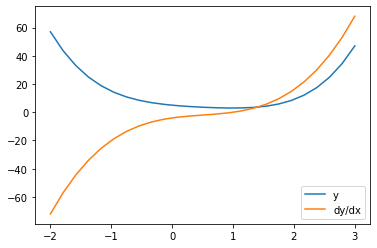

In [ ]:
# Do not change the code in this cell.
import torch

def polynomial(x):
    return x**4 - 2 * x**3 + 3 * x**2 - 4 * x + 5

xx = Leaf(torch.linspace(-2.0, 3.0, 25), 'x')
yy = polynomial(xx)
ysum = yy.sum()
forward_algorithm(ysum)
backward_algorithm(ysum, one=torch.tensor(1.0))
from matplotlib import pyplot as plt
plt.plot(xx.value, yy.result, label='y')
plt.plot(xx.value, xx.gradient, label='dy/dx')
plt.legend()
plt.show()

### Step 5 (extra credit), reproduce higher-order gradients from HW1

Your code might already do everything needed to make the higher-order derviatives in the code below work, which just passes `one=Leaf(torch.tensor(1.0))` to do the trick of building a computation graph for the gradients.  But you may be missing some details.

For extra credit, make higher-order derivatives work by getting those details right:

  * You will need to zero the gradients in the whole tree at the beginning of your backward_algorithm, since the code will be repeating the backward algorithm.  Before starting its main work, your backward_algorithm can just pass over all the graph nodes and set `node.gradient = None`.
  * Whenever you compute results, you will need to the ability to return computation graph nodes that can be further differentiated instead of plain numerical values.  You will want to do this when you are running code within the `with build_graph()` context manager.   Some code to do that has already been done in the provided `input` method in the code above; it may be enough, or you may need to add more adjustements to your code.
  * You will need to make sure any methods you call on numbers or tensors also work on nodes.  Several of the provided methods have already been written to handle this case; it may be enough, but you may need to make adjustments.

Without making significant changes to your implementation beyond the details above, the code below should work.

You should not need to change any code below.

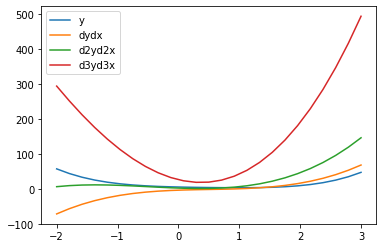

In [ ]:
# Do not change the code in this cell.
# (extra credit)
xx = Leaf(torch.linspace(-2.0, 3.0, 25), 'x')
yy = polynomial(xx)
ysum = yy.sum()
forward_algorithm(ysum)
plt.plot(xx.value, yy.result, label='y')

with build_graph():
    backward_algorithm(ysum, one=Leaf(torch.tensor(1.0)))
dydx = xx.gradient
dysum = dydx.sum()
forward_algorithm(dysum)
plt.plot(xx.value, dydx.result, label='dydx')

with build_graph():
    backward_algorithm(dysum, one=Leaf(torch.tensor(1.0)))
d2yd2x = xx.gradient
d2ysum = d2yd2x.sum()
forward_algorithm(d2ysum)
plt.plot(xx.value, d2yd2x.result, label='d2yd2x')

with build_graph():
    backward_algorithm(d2ysum, one=Leaf(torch.tensor(1.0)))
d3yd3x = xx.gradient
d3ysum = d3yd3x.sum()
forward_algorithm(d3ysum)
plt.plot(xx.value, d3yd3x.result, label='d3yd3x')
plt.legend()
plt.show()

### Step 6: Make matrix multiplication work.

Taking gradients with respect to matrix multiplications is the bread and butter of neural network training: it is what we spend most of our GPU cycles doing.

Fortunately, the computation is very similar to taking gradients of scalar products: just as `Mul` multiplies the upstream gradient by swapped inputs, `Matmul` need to matrix-multiply the upstream gradient by swapped inputs.  However, you will need to get the order of the multiplications correct, and you will need to transpose the inputs in the appropriate way.


A few hints:
  * Gradients with respect to tensors should always be the same shape as the results.
  * If you look online for advice, be aware that there are two different conventions for matrix calculus notation, one which is the transpose of the other, and if you mix them up then you can get the wrong answers.  (They are called numerator versus denominator notation; the Wikipedia entry on matrix calculus explains the differences well.)  Of the two, denominator notation is more natural for backpropagation.
  * If you are unsure, the safest way to get the right matrix operation is to expand the partial derivatives for a particular entry of the matrix by hand, and then work out which matrix multiplication is equivalent to the sum of products.
  * The easiest way to test that you have the right matrix operation is to test the code with nonrectangular inputs, and make sure that the shapes are compatible; then to check the results against pytorch.

Work through the linear algebra needed for computing partial derivatives of one or two specific entries of a matrix, and use your insights to implement `Matmul` in the `MAIN CODE` above by using matrix multiplications and transpose operations.  You should be able to pass the test below, which compares the gradients to the results given by pytorch.

In [ ]:
# Do not change the code in this cell.

A, B, C = [Leaf(torch.tensor(d, requires_grad=True), name) for name, d in [
  ('A', [[1.0, 1.0], [0.0, 1.0]]),
  ('B', [[1.0, 2.0, 1.0], [0.0, 1.0, 1.0]]),
  ('C', [[3.0, 0.0, 1.0], [1.0, 2.0, 3.0]]),
]]
loss = ((A @ B - C) ** 2).sum()

# Use our algorithm, with pytorch autograd disabled during the backward pass.
q = forward_algorithm(loss)
with torch.no_grad():
    backward_algorithm(loss, one=torch.tensor(1.0))

# Use pytorch autograd.
loss.result.backward()

# Print and compare the results.
import re
def despace(s):
    return re.sub(r"\s*", "", str(s))
for name, param in zip('ABC', [A, B, C]):
    print(f'pytorch says: dloss/d{name} = {despace(param.value.grad)}')
    print(f'our code says dloss/d{name} = {despace(param.gradient)}')
    print(f'difference: {(param.value.grad - param.gradient).norm()}')


pytorch says: dloss/dA = tensor([[10.,8.],[-10.,-6.]])
our code says dloss/dA = tensor([[10.,8.],[-10.,-6.]])
difference: 0.0
pytorch says: dloss/dB = tensor([[-4.,6.,2.],[-6.,4.,-2.]])
our code says dloss/dB = tensor([[-4.,6.,2.],[-6.,4.,-2.]])
difference: 0.0
pytorch says: dloss/dC = tensor([[4.,-6.,-2.],[2.,2.,4.]])
our code says dloss/dC = tensor([[4.,-6.,-2.],[2.,2.,4.]])
difference: 0.0


In practice, we will not implement backpropagation by hand.

Instead, we will use the autograd functionality built in to pytorch.  In pytorch, the `Tensor` objects that have set `requires_grad=True` play the role of our `ComputationNode`.  Forward computations are done immediately, and backward passes are done using `tensor.backward()` or `autograd.grad()`.  Pytorch extends the backpropagation techniques we have explored here to cover backprop through every operation that it can do on a tensor.

## Exercise 2.0.3: calculate the typical time and memory use of backprop

The following computation graph is a typical form for a deep neural network with $n$ layers, where the weights $W_i\in\mathbb{R}^{d\times d}$ are the parameters of the network, and the data $x_i\in\mathbb{R}^{d\times b}$ are the input and activation data that passes through the network as it computes a single batch of input.

<img src="typical-nn-bp-graph.png">

Suppose each each batch of data $x_i$ gathers together $b$ $d$-dimensional vectors, i.e., it can be stored as a $d\times b$ dimensional matrix.  Similarly each batch of inermediate results $z_i$ will be $d \times b$ in size.  And suppose each network weight matrix $W_i$ is a $d\times d$ dimensional matrix.

You will count up the time and space complexity of forward and backward passes.  You should answer the following four questions in big-O notation with the correct asymptotic behavior of $n$, $b$ and $d$ as they grow large (in other words, you can discard any constant factor independent of those four variables, and you can disregard terms that are dominated by terms that will always grow larger).  However, do not assume that any particular one of $n$ or $b$ or $d$ are largest; we want formulas that are asymptotically correct if any of them happens to be much larger than the others.

### Time complexity of ordinary backpropagation

First let us count $T$, the number of scalar computation operations it takes to run the forward pass or backward pass through the network.  Recall that computing $z_i = W_i x_i$ is an ordinary matrix multiplication which uses:

$$T_{\text{mm}} = O(b d^2)$$

Computing a multiplication such as $x_i z_i^T$ (muliplying a $d\times b$ by a $b\times d$ matrix to obtain a $d\times d$ result) also uses the same number of operations $T_{\text{mm}}$.

And you can assume that both the forward pass and backward pass through a single $\sigma$ or $f$ node is proportional to the input data size:

$$T_{\sigma} = O(bd)$$

  * How many scalar operations does it take to run the network in inference (compute $\mathcal{L}$ from $x_1$) without training, if gradients will not be needed?
  
$$T_{\text{run}} = \boxed{O(\text{TODO: b d^2})}$$
    

  * What if gradients might be needed, how many scalar operations does it take to run the forward pass over thr network -- is it different?
  
$$T_{\text{forward}} = \boxed{O(\text{TODO: b d^2})}$$



  * How many scalar operations will it take to run backpropagation to get gradients ${\partial{\mathcal{L}}}/{\partial{W_i}}$ on all network weights?

$$T_{\text{backward}} =\boxed{O(\text{TODO: b d^2})}$$



  * How many scalar operations will it take if we wish to run backpropagation to obtain only the gradient for the first layer weights $W_1$, i.e., we want ${\partial{\mathcal{L}}}/{\partial{W_1}}$, but we do not wish to compute gradients for other weights $W_i$ for any of the other layers $i > 1$?  Does it change the asymptotic time-complexity of the backpropagation in big-O notation?

$$T_{\text{backward-for-}W_1} =\boxed{O(\text{TODO: b d^2})}$$



### Space complexity of ordinary backpropagation


We begin by observing that, without running the network at all and just holding all the weights, the amount of memory consumed to hold the unchanging parameters is:
  
$$M_{\text{net}} = O(n d^2)$$

In the questions below, suppose that $M_{\text{net}}$ is allocated and fixed, and we are interested in estimating the additional memory needed to do computations on the network above the storage of its parameters.

  * How much memory does it take to run the network in inference (compute $\mathcal{L}$ from $x_1$) whn gradients will not be needed? (Do not include the $M_{\text{net}}$ storage of the parameters themselves.)
  
$$M_{\text{run}} = \boxed{O(\text{TODO: fill me in})}$$
    


  * How much memory does it take to run the forward pass (compute $\mathcal{L}$ from $x_1$) while building the computation graph that would be needed needed for computing gradients in the future using backprop, but without the step of actually doing backprop?  (Again do not include the $M_{\text{net}}$ storage of the parameters themselves.)
  
$$M_{\text{forward}} = \boxed{O(\text{TODO: fill me in})}$$



  * How much memory does it take to run the forward *and* backward passes to get gradients ${\partial{\mathcal{L}}}/{\partial{W_i}}$ on all network weights?  Again, do not count the network parameter memory $M_{\text{net}}$, but be sure to count the size of the newly computed gradients ${\partial{\mathcal{L}}}/{\partial{W_i}}$.

$$M_{\text{backward}} =\boxed{O(\text{TODO: fill me in})}$$



  * How much memory does it take to run the forward *and* backward passes to get gradients on just the very first layer weights $W_1$, i.e., ${\partial{\mathcal{L}}}/{\partial{W_1}}$, if we do not wish to compute gradients for other weights $W_i$ for any of the other layers $i > 1$?  (Again do not include the original parameters $M_{\text{net}}$ itself, but the output gradient should be counted.)

$$M_{\text{backward-for-}W_1} =\boxed{O(\text{TODO: fill me in})}$$

### Lessons to learn from these exercises

As you can see, backpropagation is efficient in terms of computation speed, but it obtains this speed by using potentially a lot of memory.  The amount of memory consumed by backpropagation can vary widely depending on $n$, $d$, $b$, the complexity of the computation graph, and exactly which gradients you wish to compute.  So in practice you should remember:

 * Disable autograd when you do not need gradients, because building computation graphs can consume a lot of memory.
 * Set `requires_grad=False` on any specific variables that do not need gradients, because that can also save memory.
 * You may be able to save a lot of memory by reducing your batch size $b$, depending on your model size (i.e., depending on $d$ and $n$).  Gradient accumulation can be used to accumulate larger batch gradients out of many small batches.

If you are desparate for memory because backpropagation is using too much, it is possible to change the tradeoff and spend some additional computation to do backpropagation with less memory.  The method is called [gradient checkpointing](https://github.com/cybertronai/gradient-checkpointing), and it is available in both pytorch and tensorflow. [(Pytorch documentation here.)](https://pytorch.org/docs/stable/checkpoint.html)  The idea was proposed by [Griewank (1992)](https://papers.baulab.info/also/Griewank-1992.pdf), and it works by discarding some of the intermediate results of the forward pass, and recomputing them right before they are needed during the backward pass.